In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [19]:
train = pd.read_excel("train.xlsx")
test = pd.read_excel("test.xlsx")

In [20]:
train['Цена на арматуру'] = pd.to_numeric(train['Цена на арматуру'], errors='coerce')
test['Цена на арматуру'] = pd.to_numeric(test['Цена на арматуру'], errors='coerce')

In [21]:
print(train.isnull().sum())
print(test.isnull().sum())

dt                  0
Цена на арматуру    0
dtype: int64
dt                  0
Цена на арматуру    0
dtype: int64


In [22]:
Q1 = train['Цена на арматуру'].quantile(0.25)
Q3 = train['Цена на арматуру'].quantile(0.75)
IQR = Q3 - Q1
train = train[(train['Цена на арматуру'] >= (Q1 - 1.5 * IQR)) & (train['Цена на арматуру'] <= (Q3 + 1.5 * IQR))]


In [23]:
model_sarima = SARIMAX(train['Цена на арматуру'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 52))
results_sarima = model_sarima.fit()
forecast_sarima = results_sarima.forecast(steps=len(test))

c:\Users\josha\OneDrive\Documents\GitHub\3_intensiv_3\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\josha\OneDrive\Documents\GitHub\3_intensiv_3\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\josha\OneDrive\Documents\GitHub\3_intensiv_3\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\josha\OneDrive\Documents\GitHub\3_intensiv_3\.venv\Lib\site-packages\statsmodels\

In [24]:
rf = RandomForestRegressor(n_estimators=100)
X_train = np.arange(len(train)).reshape(-1, 1)
y_train = train['Цена на арматуру']
rf.fit(X_train, y_train)
X_test = np.arange(len(train), len(train) + len(test)).reshape(-1, 1)
forecast_rf = rf.predict(X_test)

In [25]:
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(train['Цена на арматуру'].values.reshape(-1, 1))

X_train_lstm, y_train_lstm = [], []
for i in range(5, len(train_scaled)):
    X_train_lstm.append(train_scaled[i-5:i, 0])
    y_train_lstm.append(train_scaled[i, 0])
X_train_lstm, y_train_lstm = np.array(X_train_lstm), np.array(y_train_lstm)
X_train_lstm = np.reshape(X_train_lstm, (X_train_lstm.shape[0], X_train_lstm.shape[1], 1))

model_lstm = Sequential()
model_lstm.add(LSTM(units=50, return_sequences=True, input_shape=(X_train_lstm.shape[1], 1)))
model_lstm.add(Dropout(0.2))
model_lstm.add(LSTM(units=50))
model_lstm.add(Dropout(0.2))
model_lstm.add(Dense(1))
model_lstm.compile(optimizer='adam', loss='mean_squared_error')
model_lstm.fit(X_train_lstm, y_train_lstm, epochs=50, batch_size=32)

inputs = scaler.transform(test['Цена на арматуру'].values.reshape(-1, 1))
X_test_lstm = []
for i in range(5, len(inputs)):
    X_test_lstm.append(inputs[i-5:i, 0])
X_test_lstm = np.array(X_test_lstm)
X_test_lstm = np.reshape(X_test_lstm, (X_test_lstm.shape[0], X_test_lstm.shape[1], 1))
forecast_lstm = model_lstm.predict(X_test_lstm)
forecast_lstm = scaler.inverse_transform(forecast_lstm)

c:\Users\josha\OneDrive\Documents\GitHub\3_intensiv_3\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.1498
Epoch 2/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0239 
Epoch 3/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0193 
Epoch 4/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0117 
Epoch 5/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0096 
Epoch 6/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0095 
Epoch 7/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0109 
Epoch 8/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0076 
Epoch 9/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0067 
Epoch 10/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0077 
Epoch 11/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0079 
Epoch 12/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0073 
Epoch 13/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0074 
Epoch 14/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0092 
Epoch 15/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0082 
Epoch

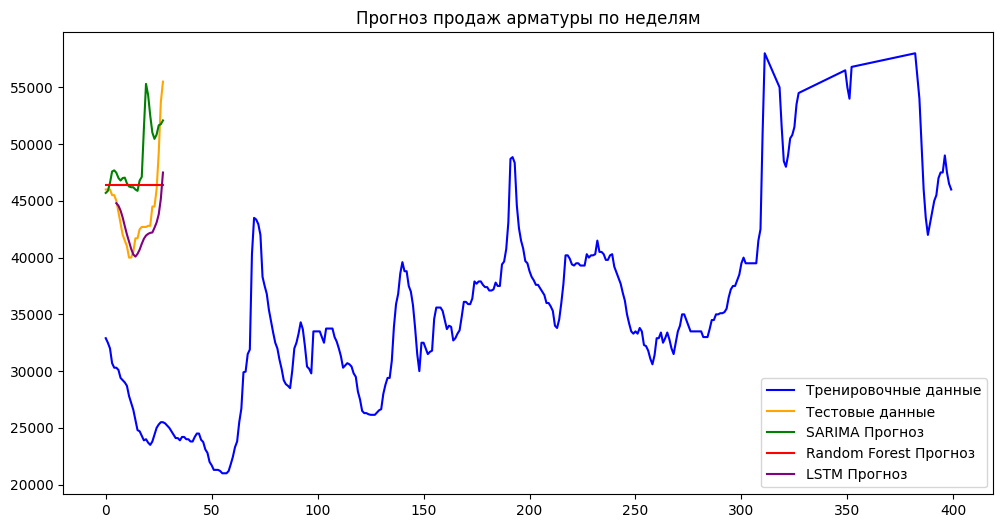

In [26]:
plt.figure(figsize=(12, 6))
plt.plot(train.index, train['Цена на арматуру'], label='Тренировочные данные', color='blue')
plt.plot(test.index, test['Цена на арматуру'], label='Тестовые данные', color='orange')
plt.plot(test.index, forecast_sarima, label='SARIMA Прогноз', color='green')
plt.plot(test.index, forecast_rf, label='Random Forest Прогноз', color='red')
plt.plot(test.index[5:], forecast_lstm, label='LSTM Прогноз', color='purple')
plt.legend()
plt.title('Прогноз продаж арматуры по неделям')
plt.show()

In [27]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


In [28]:
model_arima = ARIMA(train['Цена на арматуру'], order=(1, 1, 1))  # p=1, d=1, q=1
results_arima = model_arima.fit()

# Прогнозирование с использованием ARIMA
forecast_arima = results_arima.forecast(steps=len(test))

c:\Users\josha\OneDrive\Documents\GitHub\3_intensiv_3\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\josha\OneDrive\Documents\GitHub\3_intensiv_3\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\josha\OneDrive\Documents\GitHub\3_intensiv_3\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\josha\OneDrive\Documents\GitHub\3_

In [29]:
# Если данные имеют сезонность, можно использовать SARIMA, как вы уже делали:
model_sarima = SARIMAX(train['Цена на арматуру'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 52))  # p=1, d=1, q=1, seasonal_p=1, seasonal_d=1, seasonal_q=1, сезонность в 52 недели
results_sarima = model_sarima.fit()
forecast_sarima = results_sarima.forecast(steps=len(test))

c:\Users\josha\OneDrive\Documents\GitHub\3_intensiv_3\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\josha\OneDrive\Documents\GitHub\3_intensiv_3\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\josha\OneDrive\Documents\GitHub\3_intensiv_3\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\josha\OneDrive\Documents\GitHub\3_intensiv_3\.venv\Lib\site-packages\statsmodels\

In [30]:
model_arma = ARIMA(train['Цена на арматуру'], order=(1, 0, 1))  # p=1, d=0, q=1
results_arma = model_arma.fit()

# Прогнозирование с использованием ARMA
forecast_arma = results_arma.forecast(steps=len(test))

c:\Users\josha\OneDrive\Documents\GitHub\3_intensiv_3\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\josha\OneDrive\Documents\GitHub\3_intensiv_3\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\josha\OneDrive\Documents\GitHub\3_intensiv_3\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\josha\OneDrive\Documents\GitHub\3_

In [31]:
model_iarma = ARIMA(train['Цена на арматуру'], order=(1, 1, 1))  # p=1, d=1, q=1
results_iarma = model_iarma.fit()

# Прогнозирование с использованием IARMA
forecast_iarma = results_iarma.forecast(steps=len(test))


c:\Users\josha\OneDrive\Documents\GitHub\3_intensiv_3\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\josha\OneDrive\Documents\GitHub\3_intensiv_3\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\josha\OneDrive\Documents\GitHub\3_intensiv_3\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\josha\OneDrive\Documents\GitHub\3_

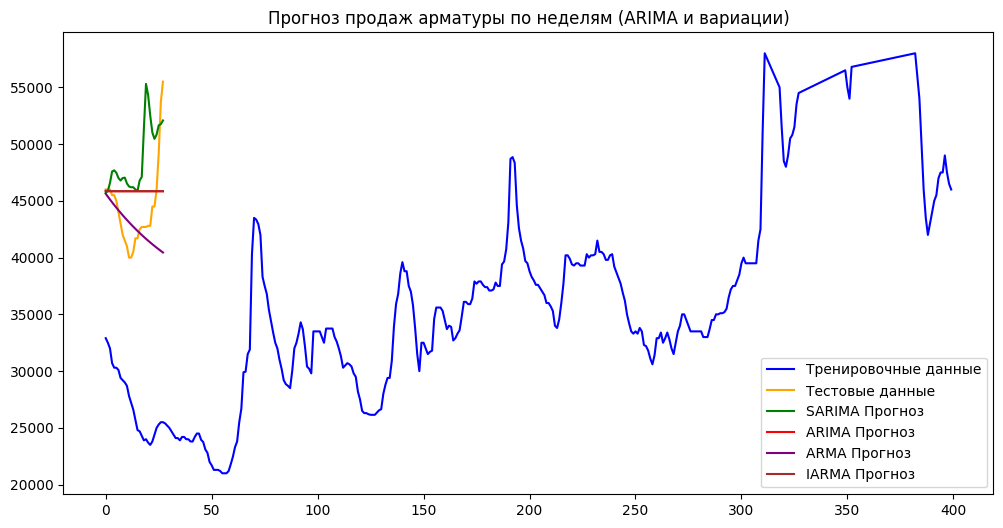

In [32]:
plt.figure(figsize=(12, 6))
plt.plot(train.index, train['Цена на арматуру'], label='Тренировочные данные', color='blue')
plt.plot(test.index, test['Цена на арматуру'], label='Тестовые данные', color='orange')

# Прогнозы для всех моделей
plt.plot(test.index, forecast_sarima, label='SARIMA Прогноз', color='green')
plt.plot(test.index, forecast_arima, label='ARIMA Прогноз', color='red')
plt.plot(test.index, forecast_arma, label='ARMA Прогноз', color='purple')
plt.plot(test.index, forecast_iarma, label='IARMA Прогноз', color='brown')

plt.legend()
plt.title('Прогноз продаж арматуры по неделям (ARIMA и вариации)')
plt.show()

SARIMA: R² = 1.0000, MSE = 31890855.9834, RMSE = 5647.1990, MAE = 4770.5863, MAPE = nan%, SMAPE = nan%
ARIMA: R² = 1.0000, MSE = 15372343.4411, RMSE = 3920.7580, MAE = 3129.9283, MAPE = nan%, SMAPE = nan%
ARMA: R² = 1.0000, MSE = 20218852.8285, RMSE = 4496.5379, MAE = 2685.0211, MAPE = nan%, SMAPE = nan%
IARMA: R² = 1.0000, MSE = 15372343.4411, RMSE = 3920.7580, MAE = 3129.9283, MAPE = nan%, SMAPE = nan%
